In [2]:
from os.path import join,expanduser
import sys
import cmocean as cmo
# identify user's home directory
user_home_dir = expanduser('~')
# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import botocore
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()

        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()

    return credentials
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False

    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'],
                           token=credentials['sessionToken'])

    return s3, credentials
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """
    This routine returns the in-memory size of an python object
    
    Returns:
    =======
    
    size: size of object & members.
    """
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size


In [5]:
## 1. LOAD MONTHLY ICE CONCENTRATION DATA ======================
directory     = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/SEA_ICE_CONC_THICKNESS')
# list sub-directories (one per dataset) 1992 - 2019
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(directory.glob('*')))
monthly_tile  = [[] for _ in range(12)]
tilesel       = 0
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):
    ds        = xr.open_dataset(file_path);
    month_idx = int(ds.time.dt.month.item()) - 1 # Extract month (1–12), convert to index (0–11)
    ds_tile0  = ds.sel(tile = tilesel) # Select only tile 0 and drop tile dimension
    monthly_tile[month_idx].append(ds_tile0)
### Create the climatology of sea ice concentration ##
climon    = []
for i in range(0,12):
  print("I am in month",i)
  var     = monthly_tile[i]
  mon_all = xr.concat(var, dim='time')
  monclim = mon_all.mean(dim='time',skipna="True")
  climon.append(monclim)




I am in month 0
I am in month 1
I am in month 2
I am in month 3
I am in month 4
I am in month 5
I am in month 6
I am in month 7
I am in month 8
I am in month 9
I am in month 10
I am in month 11


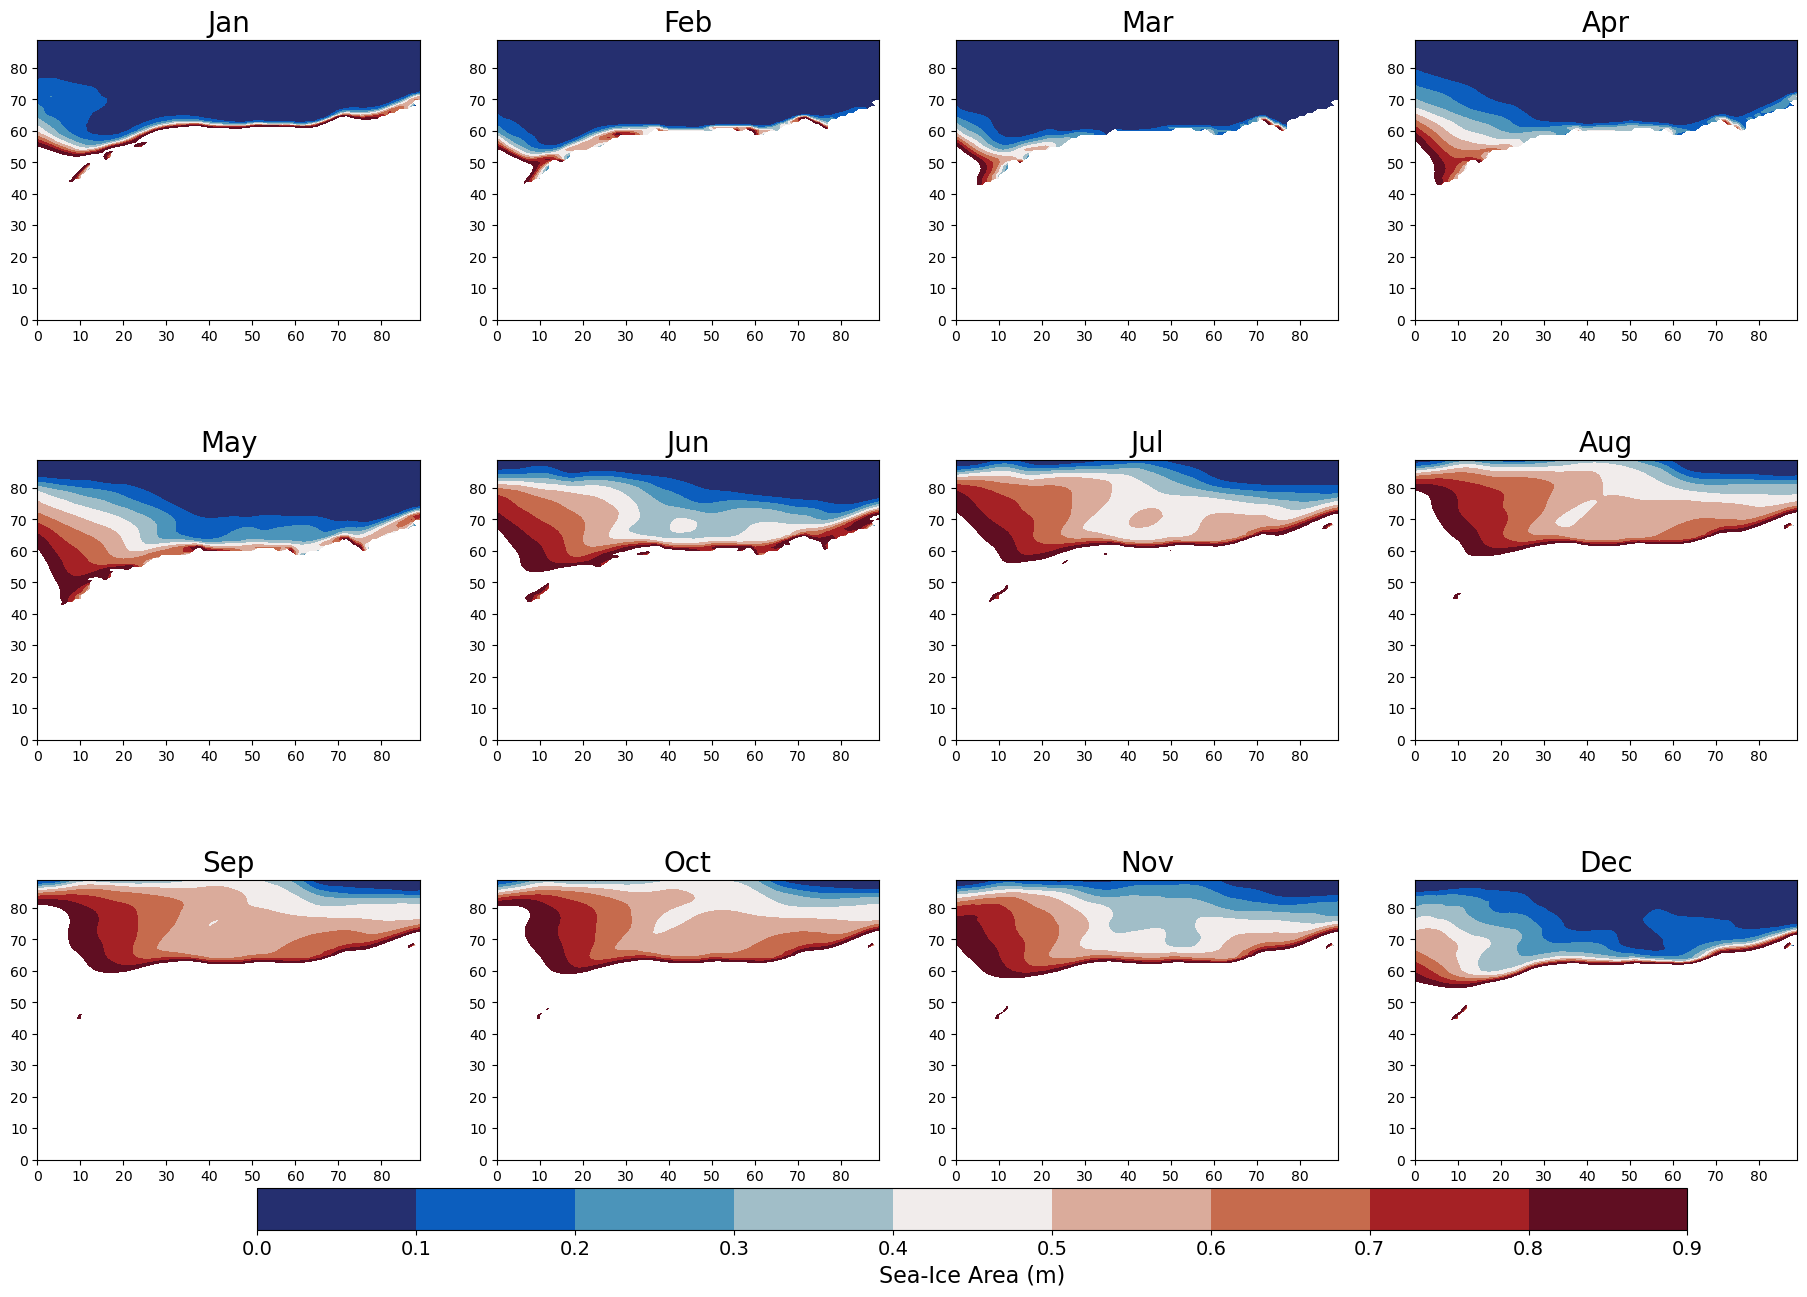

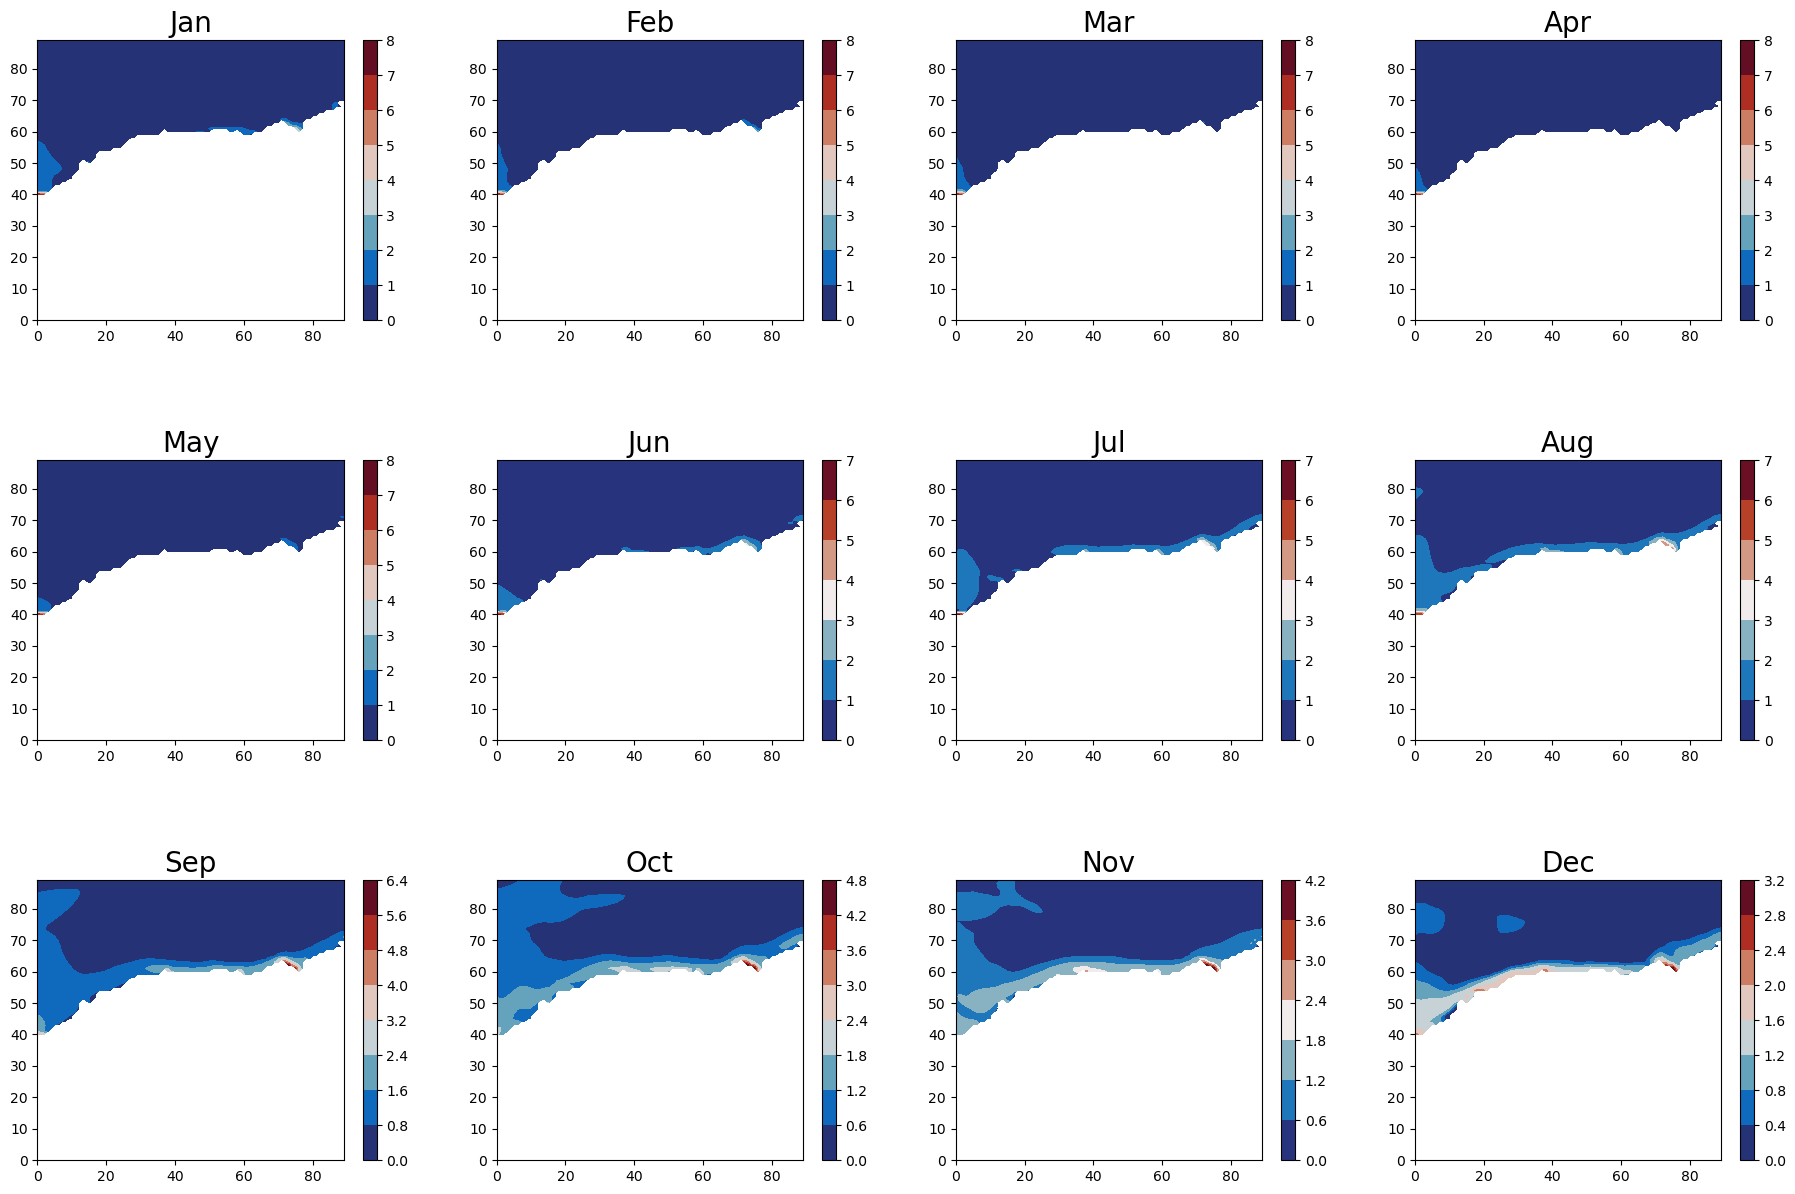

In [6]:
## ---------- PLOT the climatology pf sea ice concentration here ---------------------------------
montitles = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
cmin      = 0;cmax=1;cstep=0.1
nrow      = 3;ncol=4;figca      = []
fig, axs  = plt.subplots(nrow,ncol,figsize=(22,14))
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
axis      = fig.axes
colorm    = cmocean.cm.balance
for a in range (0,12):
  sic     = axis[a].contourf(climon[a].SIheff,levels = np.arange(cmin,cmax,cstep),cmap = colorm)
  axis[a].set_title(montitles[a],fontsize=20)
### - - - - - COLORBAR SPECIFICATIONS - - - - - -
cbar_ax = fig.add_axes([0.2, 0.05, 0.65, 0.03])  # [left, bottom, width, height]
bounds  = np.arange(cmin, cmax+cstep, cstep)
cbar    = fig.colorbar(sic,    cax=cbar_ax,orientation='horizontal',ticks=bounds,spacing='uniform')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Sea‐Ice Area (m)', fontsize=16)

## -- -- ------------------- 2016 Sea Ice coverage ---- -- ---- 
directory = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/SEA_ICE_CONC_THICKNESS')
ecco_v4r5_mon_mean_native_dataset_paths2 = np.sort(list(directory.glob('*2005-*.nc')))
monthly_2016tile = [[] for _ in range(12)]
tilesel   = 0
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths2):
    ds        = xr.open_dataset(file_path);
    month_idx = int(ds.time.dt.month.item()) - 1 # Extract month (1–12), convert to index (0–11)
    ds_tile0  = ds.sel(tile=tilesel) # Select only tile 0 and drop tile dimension
    monthly_2016tile[month_idx].append(ds_tile0)

## ---------- PLOT the sea ice anomaly here ---------------------------------
montitles = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
cmin      = -1;cmax=1;cstep=0.1
nrow      = 3;ncol=4;figca      = []
fig, axs  = plt.subplots(nrow,ncol,figsize=(22,14))
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
axis      = fig.axes
colorm    = cmocean.cm.balance
for a in range (0,12):
    sic = axis[a].contourf(monthly_2016tile[a][0].SIheff[0,:,:],cmap = colorm);fig.colorbar(sic)
    axis[a].set_title(montitles[a],fontsize=20)
